## Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# database libraries
import sqlite3 as s3
from sqlalchemy import create_engine

In [2]:
import os

for file in os.listdir("../input"):
    _ = os.stat(os.path.abspath(".././input/"+file)).st_size / 1024 / 1024
    print(f"File name : {file} and file size is {_:.2f} MB")

os.stat(os.path.abspath(".././input/Train.csv"))

File name : Test.csv and file size is 2253.54 MB
File name : Train.csv and file size is 6917.87 MB
File name : SampleSubmission.csv and file size is 78.72 MB
File name : train.db and file size is 8309.86 MB


os.stat_result(st_mode=33152, st_ino=103, st_dev=36, st_nlink=1, st_uid=0, st_gid=0, st_size=7253917400, st_atime=1647212094, st_mtime=1374504622, st_ctime=1647212094)

<p style = "color: red"> We have two files in the input for started, each one of them above 1 GB. In order to make the analysis easier to run on computer, <b>we will only be using the train file</b> for which we have the answers avaialable. For the test file, the predictions need to be submitted on kaggle, so it is of no use for the initial analysis</p>

## Reading input data and saving to a database

In [3]:
%cd ../input

/content/gdrive/MyDrive/Colab Notebooks/Keywork-Extraction-Kaggle-Stackoverflow/input


In [118]:
# Since the files are very big, it is not possible to load it in RAM and work with it
# We will make use of sqlite databases to run the operations

import sqlite3 as s3
from sqlalchemy import create_engine

prefix = lambda filename: "../input/"+filename

if not os.path.isfile(prefix("train.db")):
    # The database has not yet been initiated
    
    engine = create_engine("sqlite:///train.db")
    chunk = 180000   # 180k rows read at a time
    
    j = 0
    start_index = 1
    
    print("Reading data to sql database train.db\n" + "*"*30 + "\n")
    
    for data in pd.read_csv(prefix("Train.csv"), names=["Id", "Title", "Body", "Tags"], skiprows=1 \
        , chunksize=chunk, iterator=True, encoding="utf-8"):
        
        j+=1
        print(f"Rows read: {j*chunk}", end='\r')
        
        data.to_sql("data", engine, if_exists="append")
    

Reading data to sql database train.db
******************************



<p style = "color: red"> 
Here are few key observations:
<ol style = "color: red">
    <li>There are over 6 million questions in the training datasets</li>
    <li>Time taken to read the input data was over 30 minutes</li>
    <li>Data read is stored in a database instead of storing it in memory</li>
</ol>
</p>

In [54]:
with s3.connect("train.db") as con:
     xhead= pd.read_sql_query("""
                          SELECT Title, Body, Tags
                          FROM data 
                          LIMIT 100 
                          """, con)
    
xhead.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


As we can wee, there are 3 key columns:
* Title - this is the title of the question posted on SO
* Body - contains the body including the code snippets etc
* Tags - the tags that we want to predict for new questions

In [55]:
import IPython
import ipywidgets as widgets

@widgets.interact(i = (0, 10))
def fun(i):
    return IPython.display.HTML(f"<h3>Label</h3><h4><code>{xhead.Tags[i].split()}</code></h4><hr>" + f"<h2>{xhead.Title[i]}</h2>" + xhead.Body[i])
    

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

### Count the total number of rows

In [6]:
with s3.connect("train.db") as con:
    x = pd.read_sql_query("""
                          SELECT count(*) 
                          FROM data 
                          """, con)
    
x

,count(*)
0,6034195


Since this is a questions database, there is quite a possibility that one question is posted more than once 
by the same user. So, we want to remove all such duplicates

### Removing duplicate questions and deep-dive

In [8]:
!pwd

# !echo %cd%

/content/gdrive/MyDrive/Colab Notebooks/Keywork-Extraction-Kaggle-Stackoverflow/input


In [9]:
with s3.connect("train.db") as con:
    
    # cur = con.cursor()
    con.execute('PRAGMA max_page_count = 2147483646')
    
    data_grouped = pd.read_sql_query("""
                                Select Title, Body, Tags, count(*) as duplicate_count
                                from data 
                                group by Title, Body, Tags
                                """, con)

In [26]:
data_grouped.head(2)

,Title,Body,Tags,duplicate_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1


In [56]:
# We will store the condensed data so that it is easier to load the next time

engine = create_engine("sqlite:///train.db")
data_grouped.to_sql("data_no_dupes", engine, if_exists="append")

In [62]:
# Let's look at the tables in our updated database

with s3.connect("train.db") as con:
    _ = pd.read_sql_query("""
    SELECT distinct tbl_name FROM sqlite_master
    """, con)
_

,tbl_name
0,data
1,data_no_dupes


In [ ]:
del data_grouped

In [5]:
# let's read data from the database directly
%cd ../input
!pwd

engine = create_engine("sqlite:///train.db")
data_grouped = pd.read_sql_table("data_no_dupes", engine)

data_grouped.head(1)

/content/gdrive/MyDrive/Colab Notebooks/Keywork-Extraction-Kaggle-Stackoverflow/input
/content/gdrive/MyDrive/Colab Notebooks/Keywork-Extraction-Kaggle-Stackoverflow/input


,index,Title,Body,Tags,duplicate_count
0,0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1


The reduced data can be read in around 2 minutes now

## Understand the duplication pattern

We will try to dig deep and understand how many questions repeat, and what is the size of new dataframe after reducing the duplicated

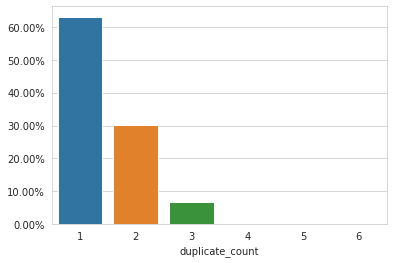

In [47]:
import seaborn as sns
sns.set_style("whitegrid")

x = data_grouped.loc[:, ["duplicate_count"]].groupby(by = "duplicate_count").size()
x = x / sum(x)

ax = sns.barplot(x.index, x)
ylabels = ax.get_yticks()
ax.set_yticklabels([f"{i:.2%}" for i in ylabels])
plt.show()

In [53]:
6034195 - data_grouped.shape[0]

1827881

This goes to show that:
1. There were 2 million duplicates in the dataset, or __35 percent__
2. Around 30 percent of the questions had at least 1 duplicate
3. Very few, around 4 percent, of the questions had 2 or more duplicates